In [10]:
import numpy as np
import os #???
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [23]:
class AdalineSGD:
    
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None): #???None
        # Initialize parameters
        # Learning rate
        self.eta = eta
        # Number of iterations during training. Also seems to be called number of epochs.
        self.n_iter = n_iter
        
        self.w_initialized = False #???
        
        self.shuffle = shuffle
        
        # random_state: used to initialize a random number generator. 
        # The weights and bias will be randomly initialized, and this requires a random number generator.
        self.random_state = random_state
        
    def fit(self, X, y):
        # Fit the model to data (adjusting weights and bias)
        
        # The codes for initialization are put in the function 'self._initialize_parameters'
        self._initialize_parameters(X.shape[1])
        
        # Values of the loss function during iteration
        self.losses_ = []
        
        n = X.shape[0] # Number of training examples
        
        for _ in range(self.n_iter): #??? _
            if self.shuffle:
                X, y = self._shuffle(X,y)
            losses = [] # Used to store the loss for each update. Then it is averaged to get a mean loss for a single epoch
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        
        
        return self
                
    def _initialize_parameters(self, m): #??? _name?
        # Random generator
        # Initialize the generator.
        # self.random_state is a seed. rgen is a pseudo-random number generator. If the seed does not change, the result won't change either.
        rgen = np.random.RandomState(self.random_state) 
        # randomly generate weights from a normal distribution
        # loc: mean
        # scale: standard deviation
        # size: if it is a number, then return a random number. If it is a tuple, e.g. (2,3), then return an array.
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=m)
        # Note that X.shape[1] is the number of features. The number of weights is equal to the number of features
        # Since X.shape[1] is a scalar, self.w_ is a 1D array.
         # Initialize the bias as zero.
        # np.float_ is the float type in numpy
        # Just ignore the difference between np.float and the float type in python at the moment.
        self.b_ = np.float_(0.)
        
        self.w_initialized = True #???
        
    def _shuffle(self, X,y):
        # Shuffle the training data
        # Note that self.rgen is defined first in self._initialize_parameters
        rgen = np.random.RandomState(self.random_state)
        r = rgen.permutation(len(y)) # The result is an array
        return X[r], y[r]
        
    def _update_weights(self, xi, target):
        z = self.net_input(xi)
        output = self.activation(z)
        error = output - target
        self.w_ -= self.eta * error * xi
        self.b_ -= self.eta * error
        loss = error**2 / 2
        return loss
        
    def net_input(self, X):
        # We need to calculate z = w.x+b for each example
        # But this can be done for all examples simultaneously.
        # Note that self.w_ is a 1D array. np.dot(X, self.w_) gives a 1D array, not a column vector
        # If self.w_ is a column vector, np.dot(X,self.w_) is also a column vector
        # Thus, this function returns a 1D array, containing net inputs for all training examples.
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, z):
        # The sigma function in the book
        # Here, sigma(z)=z
        return z
    
    def predict(self, X):
        return np.where(self.net_input(X)>=0.5, 1, 0)
        # np.where: if the condition is true, return the first value, otherwise the second.
        # the condition self.net_input(X)>=0.5 is actually a 1D array, so the output is also a 1D array
        # The output of np.where has the same shape as the condition
    

In [12]:
# Loading data
# Data source
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

# Read data directly from the URL
df = pd.read_csv(s, header=None, encoding='utf-8')

# Create labels
# 'Iris-setosa' --> 0   'Iris-virginica' --> 1
y = df.iloc[0:100, 4].values   
y = np.where(y == 'Iris-setosa', 0, 1)
# Get two features
X = df.iloc[0:100, [0,2]].values

Text(0, 0.5, 'log(loss)')

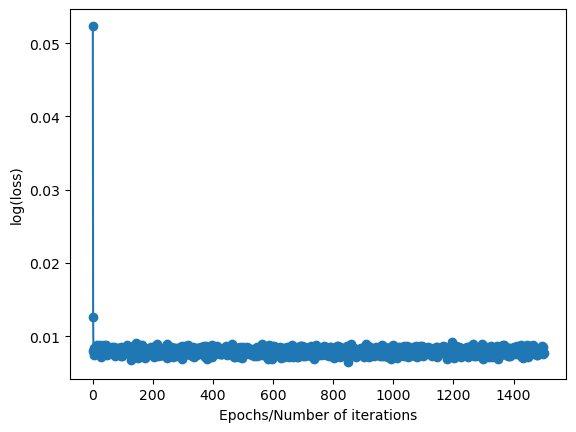

In [24]:
# Train Adaline, with a smaller learning rate
ada_sg = AdalineSGD(eta=0.01, n_iter=1500, random_state=1)
ada_sg.fit(X,y)
# Plot misclassification
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(ada_sg.losses_)+1), (ada_sg.losses_), marker='o')
ax.set_xlabel('Epochs/Number of iterations')
ax.set_ylabel('loss')
# Note that the figure may not be the same as the one in the book.
# If we change the value of 'random_state', then we may get the figure in the book.

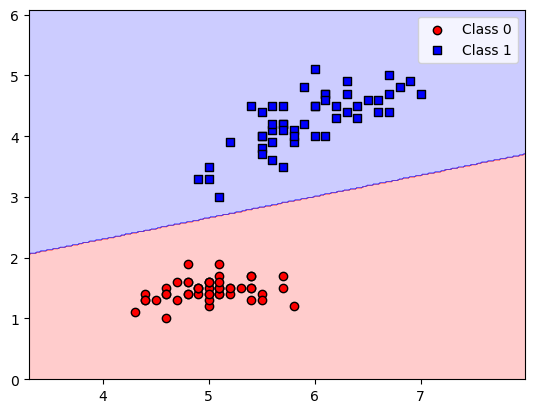

In [26]:
# Visualizing the decision boundary
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Create lists of markers and colors
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    
    # np.unique: find the unique elements of an array
    # The output y only has two possible values, 0 and 1. Therefore np.unique(y) is 2.
    # Then colors[:len(np.unique(y))] is colors[:2], i.e., colors = ('red', 'blue')
    # This is suitable for discrete colors.
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Set the range 
    # The range of the figure is larger than the range of the features.
    # Prevent data points from lying on the edges of the figure.
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 
    # Generate meshgrid
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    # np.ravel(): flatten an array. It returns a 1D-array
    # The input of the function 'predict' is X. Each column of X corresponds to a feature.
    # Therefore, after raveling, we need to transpose the array.
    # lab: labels for all grid points
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # The output of 'predict' is a 1D-array. It is reshaped to have the same shape as xx1
    lab = lab.reshape(xx1.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    # alpha: control the transparency
    ax.contourf(xx1, xx2, lab, alpha=0.2, cmap=cmap)
    
    # Plot training examples
    # enumerate: 
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y==cl,0], y=X[y==cl,1], alpha=1, c=colors[idx], marker=markers[idx], label='Class {}'.format(cl), edgecolor="black")
    ax.legend()
    
plot_decision_regions(X, y, ada_sg)

In [27]:
# Feature scaling
X_std = np.copy(X)
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_std = (X - mu)/std

Text(0, 0.5, 'loss')

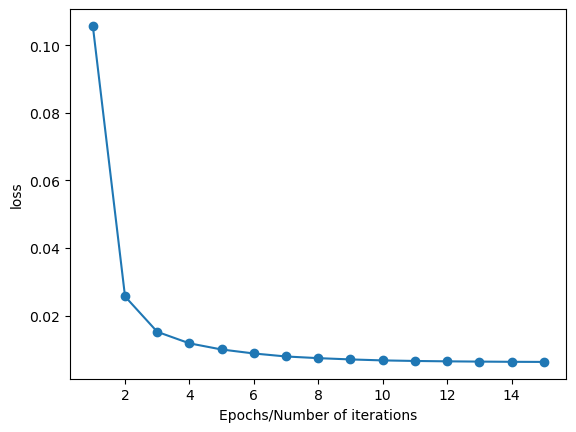

In [35]:
ada_sgd_fs = AdalineSGD(n_iter=15, eta=0.01)
ada_sgd_fs.fit(X_std, y)
# Plot misclassification
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(ada_sgd_fs.losses_)+1), (ada_sgd_fs.losses_), marker='o')
ax.set_xlabel('Epochs/Number of iterations')
ax.set_ylabel('loss')

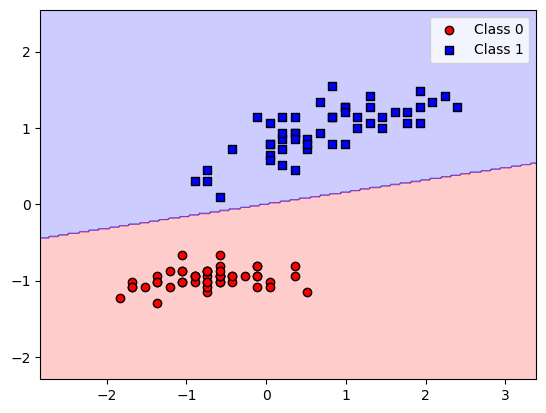

In [34]:
plot_decision_regions(X_std, y, ada_sgd_fs)